# Business Understanding
## How do the listing prices vary during the calendar?
* To answer this question, I analyse the calendar data from Seattle Airbnb open data from 2016.

In [1]:
# Import neccessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns
import pickle as pkl
import folium
from folium.plugins import HeatMap
import numpy as np
%matplotlib inline

In [2]:
#If you have not yet installed ipynb,uncomment the line below first
#!pip install ipynb
# Import customarized functions from my_functions notebook
from ipynb.fs.full.my_functions import cat_counts
from ipynb.fs.full.my_functions import stats_description

# Data Understanding

In [3]:
df = pd.read_csv('Seattle_data/calendar.csv')
df.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [4]:
# Summary of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
listing_id    1393570 non-null int64
date          1393570 non-null object
available     1393570 non-null object
price         934542 non-null object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


* We see that the price column is registered as an object and not as a float or int.
* This means that the price is a categorical column.
* We shall convert it to a numeric feature first before carrying out the analysis.

In [5]:
# The price column is missing some values.
# I will do a missing values count first.
df['price'].isnull().value_counts()

False    934542
True     459028
Name: price, dtype: int64

# Data Preparation
* In this section, I will start by converting the price column into a numeric feature by removing the dollar sign
* The number of missing prices is very large.
* Filling the missing values with the mean prices would have been a good idea but this will alter the meaning of the data.
* Missing prices for a given a listing id might mean 2 things; 1. the host had no guests, hence no price offered or 2. the host had a long stay guest.
* Based on these reasons, I will drop all rows with missing prices.
* Convert the date column from an object to a datetime 
* We shall then process to create features from the date column (day of the week, month and year).
* All the steps above will be performed in the clean_calendar function below.

In [6]:
def clean_calendar(df):
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    clean_df - A dataframe with mssing values removed or interpolated
    
    This function cleans df using the following steps to produce X and y:
    1. Drop all the rows with no prices
    2. Remove the dollar sign and convert the price column into a numeric feature.
    3. Convert the date column from an object to a datetime 
    4. Create calendar features from the date column
    5. Convert the dat of week to the name of the day instead of a number
    6. Convert the month to the name of the month instead of a number
    7. Save a new dataframe.
    '''
    #Remove rows with missing price
    
    df = df.dropna(subset=['price']).copy()
    
    #Remove dollar signs
    fees = df[['price']].columns
    for col in fees:
        df[col] = df[col].astype(str).str.replace('$','')
        df[col] = df[col].astype(str).str.replace(',','').astype('float') 
            
    # Fill numeric columns with the mean
    num_df = df[['price']].columns
    for col in num_df:
        df[col].fillna((df[col].mean()), inplace=True)
    
    #Convert the Date column in datetime
    df['date'] =pd.to_datetime(df['date']).copy()
    
    #Create split date into Day, month and year
    df['Year'] = df['date'].apply(lambda time: time.year)
    df['Month'] = df['date'].apply(lambda time: time.month)
    df['Day of Week'] = df['date'].apply(lambda time: time.dayofweek)
    
    #Convert day of week to Name
    dmap = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
    df['Day of Week'] = df['Day of Week'].map(dmap)
    
    #Convert day of Month
    mmap = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
    df['Month'] = df['Month'].map(mmap)
    return df 

In [7]:
clean_calendar = clean_calendar(df)

In [8]:
clean_calendar .info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 934542 entries, 0 to 1393213
Data columns (total 7 columns):
listing_id     934542 non-null int64
date           934542 non-null datetime64[ns]
available      934542 non-null object
price          934542 non-null float64
Year           934542 non-null int64
Month          934542 non-null object
Day of Week    934542 non-null object
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 57.0+ MB


In [9]:
# Statistical summary of the prices
clean_calendar['price'].describe()

count    934542.000000
mean        137.944859
std         105.062870
min          10.000000
25%          75.000000
50%         109.000000
75%         160.000000
max        1650.000000
Name: price, dtype: float64

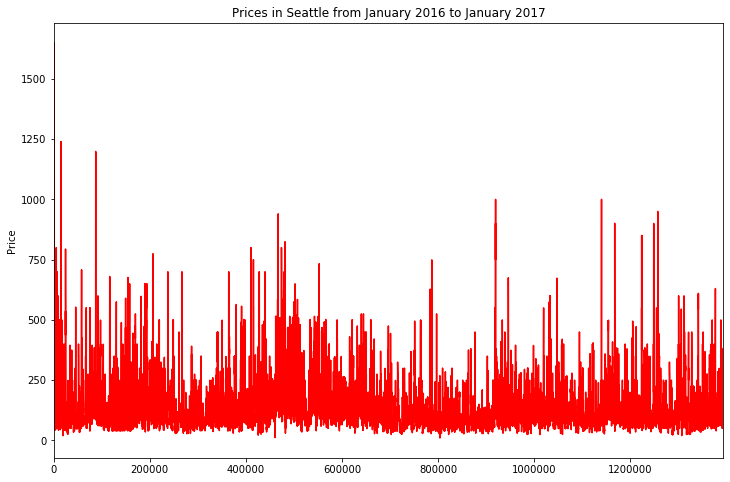

In [10]:
# Prices 
plt.figure(figsize=(12, 8))
clean_calendar['price'].plot(c='r')
plt.ylabel('Price')
plt.title('Prices in Seattle from January 2016 to January 2017');

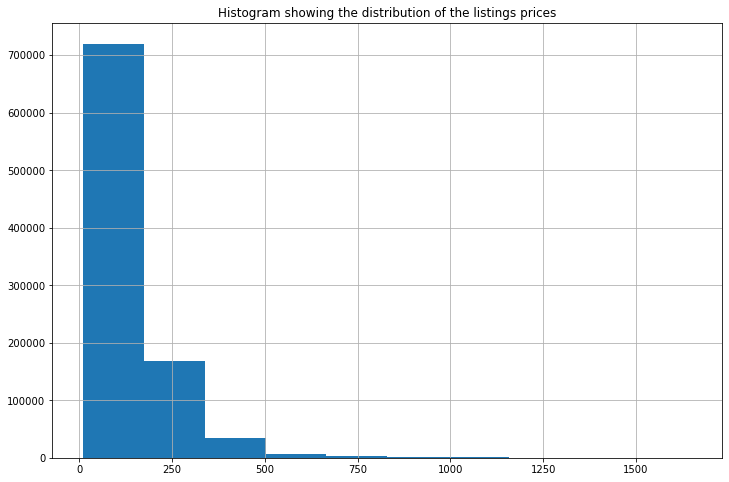

In [11]:
plt.figure(figsize=(12, 8))
clean_calendar['price'].hist()
plt.title('Histogram showing the distribution of the listings prices');

# Modelling
* In this section we use the customarized function Stat_description to analyse how the prices change with the different calendar features.
* Since the available data was limited to 2016, we will mainly focus on the days of the week, months and seasons. 

# How do the listing prices vary during the calendar?

### How do the prices vary with the days of the week?

In [12]:
# Pass df, col1 and col2 in the stats_description function
stats_description(clean_calendar,"Day of Week","price")

,mean_price,median_price,std_price,max_price,min_price,5th perc_price,95th perc_price
Fri,143.036294,111.0,107.347692,1650.0,20.0,111.0,350.0
Mon,135.676414,105.0,104.007297,1650.0,10.0,105.0,325.0
Sat,143.202136,113.0,107.441564,1650.0,20.0,113.0,350.0
Sun,136.459941,105.0,104.225783,1650.0,20.0,105.0,325.0
Thu,136.476032,105.0,104.707416,1650.0,12.0,105.0,333.0
Tue,135.408764,105.0,103.762102,1650.0,20.0,105.0,325.0
Wed,135.447880,105.0,103.555339,1650.0,20.0,105.0,325.0


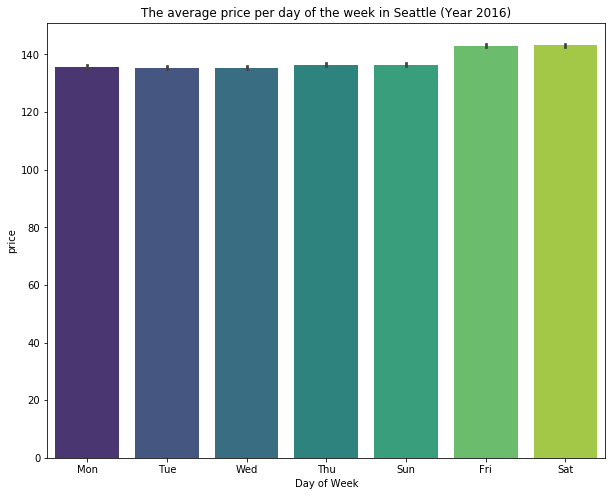

In [13]:
# Barplot
plt.figure(figsize=(10, 8))
ax = sns.barplot(x="Day of Week", y="price",data=clean_calendar,palette='viridis');
plt.title('The average price per day of the week in Seattle (Year 2016)');

# Results
* On avearge the prices are highest on Friday and Saturday.
 This is expected because people tend to go for weekend get-aways hence a slight increase in the demand for accomodation.
* The prices from Monday to Thursday are relatively lower and fixed compared with the former.

### How do the prices vary with the months?

In [14]:
# Pass df, col1 and col2 in the stats_description function
stats_description(clean_calendar,"Month","price")

,mean_price,median_price,std_price,max_price,min_price,5th perc_price,95th perc_price
Apr,135.097005,110.0,98.232098,1099.0,20.0,110.0,300.0
Aug,150.656594,114.0,118.754189,1250.0,20.0,114.0,399.0
Dec,137.251835,109.0,105.101659,1650.0,20.0,109.0,325.0
Feb,124.293927,100.0,91.550076,1000.0,20.0,100.0,275.0
Jan,122.912176,99.0,88.708143,1000.0,12.0,99.0,275.0
Jul,152.094150,115.0,120.078098,1240.0,20.0,115.0,400.0
Jun,147.473137,110.0,112.481803,1099.0,20.0,110.0,375.0
Mar,128.644488,100.0,94.371410,1099.0,20.0,100.0,285.0
May,139.538183,110.0,102.863280,1099.0,20.0,110.0,325.0
Nov,135.688738,106.0,104.264654,1650.0,10.0,106.0,315.0


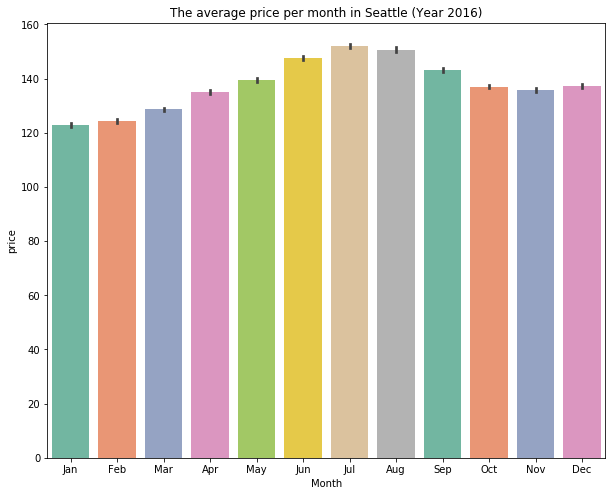

In [15]:
# Barplot
plt.figure(figsize=(10,8))
ax = sns.barplot(x="Month", y="price",data=clean_calendar,palette='Set2');
plt.title('The average price per month in Seattle (Year 2016)');


# Results
* On average prices are highest in July. This is expected since this is the peak of the summer season.
* On average prices are lowest in January and February. 
  This is expected since these are winter months with less out-door activities and holidays hence relatively less travels and demand for accomodation.

### How do the prices vary in the days of the week in the months?
* To answer this question, I use a barplot to visualize the 3 variables in question (price, day of the week and month)

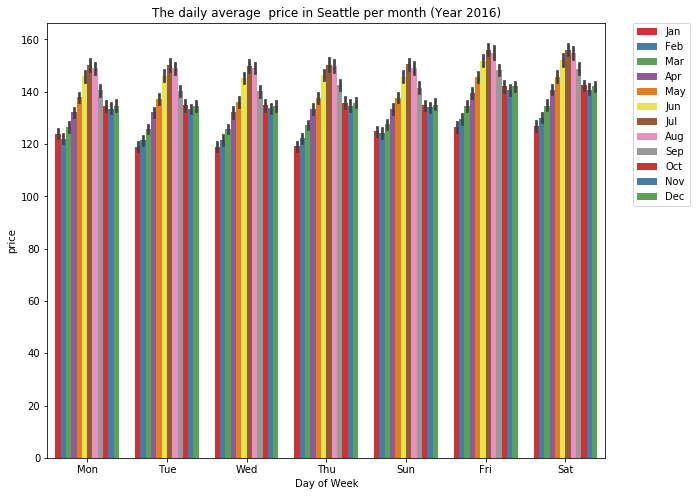

In [16]:
plt.figure(figsize=(10,8))
sns.barplot(x="Day of Week",y='price',data=clean_calendar,hue='Month',palette='Set1')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('The daily average  price in Seattle per month (Year 2016)');

# Results
* We see that there is a clear seasonal pattern of the prices during the year.
* In the days of the week we see that prices are higher during the weekend i.e Saturday and Friday compared to the week days.
* The prices are relatively higher in during the summer months i.e. July, August and June in that order.
* On the other hand, the prices are lowere in the winter months i.e. January, February and March in that order.